In [ ]:
# Workaround for training output not visible in JupyterNotebook https://github.com/microsoft/vscode-jupyter/issues/13163
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [ ]:
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys')

An image dataset of written number samples.

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [6]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

Visual representation of each pixel

In [8]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

<Axes: >

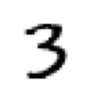

In [9]:
show_image(three_tensors[1])

Stacking all the threes together, and all the sevens together.

In [10]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [ ]:
len(stacked_threes.shape)

In [11]:
stacked_threes.ndim

3

Visual representation of the mean of all threes and sevens.

<Axes: >

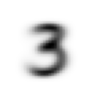

In [12]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

<Axes: >

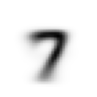

In [13]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

Create tensors from the validation directory.

In [14]:
validation_3_tensor = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
validation_3_tensor = validation_3_tensor.float()/255

validation_7_tensor = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
validation_7_tensor = validation_7_tensor.float()/255

validation_3_tensor.shape, validation_7_tensor.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Try to figure out the distance between a given digit '3' and the mean '3'. 

In [15]:
def mnist_distance(a,b):
    return (a-b).abs().mean((-1,-2))


To do it across the entire validatio nset, same code. Pytorch will expand the 'mean3' to match the dimensions of the validation_3_tensor set and perform substraction. 

In [16]:
validation_3_distance = mnist_distance(validation_3_tensor, mean3)
validation_3_distance, validation_3_distance.shape

(tensor([0.1325, 0.1463, 0.1188,  ..., 0.1571, 0.1329, 0.1611]),
 torch.Size([1010]))

A given image is a 3 if its distance to the ideal 3 is less than the distance to the ideal 7. 

In [18]:
def is_3(given): return mnist_distance(given, mean3) < mnist_distance(given, mean7)


Test the entire set of validation 3s.

In [19]:
is_3(validation_3_tensor)

tensor([True, True, True,  ..., True, True, True])

Get the mean for the entire validation set.

In [20]:
accuracy_3s = is_3(validation_3_tensor).float().mean()
accuracy_7s = (1 - is_3(validation_7_tensor).float()).mean()
accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

MNIST Loss Function
Concatenate the imges into a single tensor and change from a list of rank-3 to list of rank-2 

In [21]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [22]:
# Label each image, use 1 for '3' images and 0 for '7' images
train_y = tensor([1] * len(threes) + [0] * len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [23]:
#A Dataset in PyTorch is required to return a tuple of (x,y) when indexed. Python provides a zip function which, when combined with list, provides a simple way to get this functionality:

dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [28]:
valid_x = torch.cat([validation_3_tensor, validation_7_tensor]).view(-1, 28*28)
valid_y = tensor([1] * len(validation_3_tensor) + [0] * len(validation_7_tensor)).unsqueeze(1)
validation_dataset = list(zip(valid_x, valid_y))

In [29]:
#Now we need an (initially random) weight for every pixel (this is the initialize step in our seven-step process):

def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [32]:
weights = init_params((28*28,1))

In [34]:
bias = init_params(1)

In [43]:
# We can now calculate prediction for one image.
(train_x[0]*weights.T).sum() + bias

tensor([1.4591], grad_fn=<AddBackward0>)

In [44]:
# Using matrix multiplication to predict for the whole batch
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[  1.4591],
        [ -5.3530],
        [-11.0849],
        ...,
        [-14.4085],
        [ -2.6745],
        [ -3.4481]], grad_fn=<AddBackward0>)

In [45]:
# Now checking the accuracy
corrects = (preds > 0.0).float() == train_y
corrects

tensor([[ True],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [46]:
corrects.float().mean().item()

0.5702645778656006

In [48]:
#Now let's see what the change in accuracy is for a small change in one of the weights (note that we have to ask PyTorch not to calculate gradients as we do this, which is what with torch.no_grad() is doing here):
with torch.no_grad(): weights[0] *= 1.0001

In [49]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5702645778656006

In [50]:
# The loss functionhre is no good, the gradient of a function is its slope (Ynew-yYold/Xnew-Xold) but the accuracy doesn't change between 3s only from 3 to 7. 
# We should return a slightly higher score for 3s and slightly lower for 7s
def mnist_loss(predictions, targets):
    return torch.where(targets == 1, 1-predictions, predictions).mean()


In [51]:
# Try it
targets = tensor([1,0,1])
predictions = tensor([0.9, 0.4, 0.2])
torch.where(targets == 1, 1-predictions, predictions)

tensor([0.1000, 0.4000, 0.8000])

In [52]:
mnist_loss(predictions, targets)

tensor(0.4333)



One problem with mnist_loss as currently defined is that it assumes that predictions are always between 0 and 1. We need to ensure, then, that this is actually the case! As it happens, there is a function that does exactly that—let's take a look at Sigmoids. The sigmoid function always outputs a number between 0 and 1. It's defined as follows:

In [53]:
def sigmoid(x): return 1/(1+torch.exp(-x))

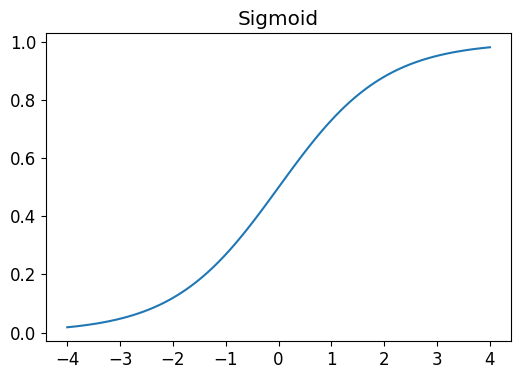

In [61]:
from fastbook import *
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [74]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1-predictions, predictions).mean()


SGD and Mini Batches
Now that we have a loss function suitable for driving SGD, the next phase is to update the weights based on the gradients. This is called optimization.

To take an optimization step, we need to calculate loss over some data items. Doing it over whole dataset would take too long and doing it over a one would be useless. The compromise is to average loss for a few items at a time.  Larger batch size means more accurate and stable estimates of gradients, but takes longer. It also helps keep the GPU busy. 

It's a good idea to vary things during training. Shuffle the items in every epoch. PyTorch and fastai provide a class to do the s huffling. 

In [63]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [64]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [66]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([19, 14,  0, 24, 20, 12]), ('t', 'o', 'a', 'y', 'u', 'm')),
 (tensor([23,  8,  9,  3, 16,  6]), ('x', 'i', 'j', 'd', 'q', 'g')),
 (tensor([ 4,  7,  1, 13,  2, 22]), ('e', 'h', 'b', 'n', 'c', 'w')),
 (tensor([ 5, 17, 18, 10, 11, 15]), ('f', 'r', 's', 'k', 'l', 'p')),
 (tensor([25, 21]), ('z', 'v'))]

Putting it all together - training loop for a model using SGD. 
Pseudocode

```
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
```

In [68]:
# Reinit parameters
weights = init_params((28*28, 1))
bias = init_params(1)


In [69]:
# Create dataloader form dataset
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [70]:
# Validation set
valid_dl = DataLoader(validation_dataset, batch_size=256)


In [71]:
# Mini batch of size 4 for testing

batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [72]:
preds = linear1(batch)
preds

tensor([[11.7548],
        [ 9.1856],
        [-2.3156],
        [-2.3829]], grad_fn=<AddBackward0>)

In [75]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.4564, grad_fn=<MeanBackward0>)

In [76]:
# Calculate gradients
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0063), tensor([-0.0398]))

In [77]:
# Put all that in a function

def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()
    

In [78]:
# Test it
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0127), tensor([-0.0796]))

In [79]:
# See what happens when calling it twice though
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0190), tensor([-0.1194]))

The gradients change because loss.backward adds the gradients of loss to currently stored gradients. Set the current gradients to 0 first.

In [80]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

In [81]:
# Update the weights and biases based on gradient and learning rate. Don't take the gradient of that step too or it gets confusing in the next batch.
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [82]:
# Check progress by looking at accuracy of validation set. 
(preds > 0.0).float() == train_y[:4]

tensor([[ True],
        [ True],
        [False],
        [False]])

In [83]:
# To get validation accuracy
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

In [84]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.5000)

In [85]:
# Put the batches together
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [86]:
validate_epoch(linear1)

0.5489

In [87]:
# That's our starting point. Let's train for one epoch, and see if the accuracy improves:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)


0.6268

In [88]:
# Do it a few more times
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')
     

0.8113 0.9114 0.9437 0.9554 0.9623 0.9662 0.9692 0.9706 0.9721 0.974 0.975 0.975 0.9755 0.9765 0.9765 0.977 0.9775 0.9775 0.9775 0.9775 

Our next step will be to create an object that will handle the SGD step for us. In PyTorch, it's called an optimizer. PyTorch has some built in modules that can be used. 

In [89]:
linear_model = nn.Linear(28*28,1)

In [91]:
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [92]:
# Create an optimizer
class BasicOptimizer:
    def __init__(self, params, learning_rate): self.params, self.learning_rate = list(params), lr

    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.learning_rate
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None
            

In [93]:
opt = BasicOptimizer(linear_model.parameters(), lr)

In [99]:
#training loop can be simplified now
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [95]:
# Validation function stays the same
validate_epoch(linear_model)

0.3565

In [97]:
#Put training loop in a function

def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [100]:
train_model(linear_model, 20)

0.4932 0.77 0.8559 0.9175 0.9355 0.9492 0.955 0.9633 0.9658 0.9682 0.9697 0.9726 0.9741 0.9746 0.976 0.976 0.9775 0.978 0.978 0.9785 

In [101]:
#fastai provides a SGD which  acts the same as BasicOptimizer class. 
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8242 0.8471 0.914 0.934 0.9482 0.9555 0.9623 0.9658 0.9677 0.9697 0.9716 0.9736 0.9751 0.976 0.9765 0.9775 0.978 0.9785 0.9785 

In [102]:
# There's also a Learner.fit which can be used instead of train_model, first build a dataloder. 
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [103]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636522,0.503513,0.495584,00:00
1,0.523197,0.179278,0.854760,00:00
2,0.191932,0.188588,0.829244,00:00
3,0.084236,0.108461,0.911678,00:00
4,0.044487,0.078286,0.934249,00:00
5,0.028955,0.062365,0.947988,00:00
6,0.022572,0.052594,0.956330,00:00
7,0.019738,0.046145,0.962218,00:00
8,0.018301,0.041634,0.965653,00:00
9,0.017439,0.038322,0.967125,00:00




As you can see, there's nothing magic about the PyTorch and fastai classes. They are just convenient pre-packaged pieces that make your life a bit easier! (They also provide a lot of extra functionality we'll be using in future chapters.)

With these classes, we can now replace our linear model with a neural network.
